# Business Understanding

## Business context

Cancellations cause significant revenue losses for the hotel business every year. Rooms that could have been occupied by other visitors are left empty due to high cancellation rates. These losses have a direct effect on profitability and pose logistical problems for staffing, guest expectations, and booking management. Peak seasons, when demand is high and cancellations lower potential earnings, make the problem even more urgent.

## Business objectives

The objecive of this project is to use historical booking data to predict whether a booking will be cancelled or not. This will allow the hotel to take preventive measures to reduce the number of cancellations and increase revenue. The model will use some information about the booking, such the number of days the booking was made in advance, the type of the customer, the number of special requests, among others, to make the prediction.

## Criteria of Sucess

In this project, it’s important for the model to correctly identify as many potential cancellations as possible to help the hotel reduce losses. Missing a cancellation (false negative) means the hotel could end up with empty rooms, losing revenue.

To evaluate the model’s success, we will use these metrics:

- Precision: Measures how many of the bookings predicted as cancellations were actually canceled.
- Recall: Measures how many actual cancellations the model was able to catch, helping minimize missed cancellations.
- F1 Score: Balances precision and recall, giving a single score for overall model reliability.

We aim for a model with high recall and a good F1 score, which would mean it’s catching most cancellations while remaining reliable. This will allow the hotel to take proactive actions to manage room availability and reduce revenue losses.

## Business questions

What are the strongest predictors of booking cancellation?
- Identifying the factors most closely associated with cancellations will help the hotel refine its policies, booking requirements, and customer engagement strategies.

How effective is the model in predicting cancellations for targeted operational adjustments?
- An effective model will empower hotel management to adjust inventory planning, overbooking policies, and pricing strategies based on cancellation likelihood.

What actions can be taken to reduce the probability of cancellation?
- By identifying high-risk bookings, the hotel can take preventative actions such as offering flexible cancellation terms, engaging high-risk customers with special offers, or adjusting rates to maintain occupancy.

# Data Understanding

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('hotel_booking.csv')

## Data exploration and preparation

### Data Selection

In [3]:
data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.00,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.00,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.00,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.00,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.00,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,Transient,96.14,0,0,Check-Out,2017-09-06,Claudia Johnson,Claudia.J@yahoo.com,403-092-5582,************8647
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,Transient,225.43,0,2,Check-Out,2017-09-07,Wesley Aguilar,WAguilar@xfinity.com,238-763-0612,************4333
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,Transient,157.71,0,4,Check-Out,2017-09-07,Mary Morales,Mary_Morales@hotmail.com,395-518-4100,************1821
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,Transient,104.40,0,0,Check-Out,2017-09-07,Caroline Conley MD,MD_Caroline@comcast.net,531-528-1017,************7860


Some columns have personal information that may not be useful for the analysis, such as the name of the person who made the reservation, the email, the phone number and the credit card number. This information does not provide any insights for predicting the cancellations, so we can drop these columns.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

The dataset has 119390 rows and 36 columns.
With the info method we can see that there are some missing values in the columns children, country and agent and company.
We have 16 columns with type object, 16 columns with type int64 and 4 columns with type float64.

In [5]:
data.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


This method provides statistics for the numerical columns, revealing that the values vary widely, with the smallest being -6.38 and the largest 5400. Such differences in ranges could impact model performance, suggesting the need for data normalization.
Since there isn’t a large gap between the mean and median, we can assume the data is not significantly skewed.
We will check these assumptions later with the help of visualizations.

In [6]:
data.describe(include='object')

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date,name,email,phone-number,credit_card
count,119390,119390,119390,118902,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390
unique,2,12,5,177,8,5,10,12,3,4,3,926,81503,115889,119390,9000
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2015-10-21,Robert Smith,Michael.C@gmail.com,422-804-6403,************3627
freq,79330,13877,92310,48590,56477,97870,85994,74053,104641,89613,75166,1461,48,6,1,28


For the object columns, we can see that the dataset has a range of unique values, from 2 to 119390. Columns with a high number of unique values or low frequency of the top value may not be useful for the analysis, so we can drop them. This reinforces the idea of dropping the columns with personal information.

In [7]:
data['reservation_status'].unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

We will also drop the 'reservation_status' and 'reservation_status_date' columns, as they provide information about when the customer checked out or if they didn't show up, which we wouldn't have access to when making the prediction.


In [8]:
data.drop(columns=['name','email','phone-number','credit_card', 'reservation_status', 'reservation_status_date'], axis = 1, inplace=True)

##### Univariate Analysis

In [9]:
numerical_columns = data.select_dtypes(exclude='object').columns
categorical_columns = data.select_dtypes(include='object').columns

In [10]:
def boxplot_visualization(data, columns, title):
    n_cols = min(5, len(columns))
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

    axes = axes.flatten()
    for i, col in enumerate(columns):
        sns.boxplot(data=data, y=col, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_ylabel("")

    for j in range(len(columns), len(axes)):
        axes[j].axis("off")

    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.suptitle(title, fontsize=16)
    plt.show()
    
def barplot_visualization(data, columns, title):
    n_cols = min(5, len(columns))
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

    axes = axes.flatten()
    for i, col in enumerate(columns):
        label = data.groupby(col).size()
        sns.barplot(x=label.index, y=label.values, ax=axes[i])
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")
        axes[i].tick_params(axis="x", rotation=45)

    for j in range(len(columns), len(axes)):
        axes[j].axis("off")

    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.suptitle(title, fontsize=16)
    plt.show()

Due to the distribution of the data we opted to use barplot for some of the numerical columns, ensuring that the visualizations are clear and easy to interpret.

In [11]:
numerical_columns_box = ['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 
 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 
 'agent', 'adr', 'total_of_special_requests']

numerical_columns_barplot = ['adults', 'children', 'babies', 'is_repeated_guest', 
 'previous_cancellations', 'booking_changes', 'required_car_parking_spaces']

categorical_columns_barplot = ['hotel', 'arrival_date_month', 'meal', 'market_segment', 
 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 
 'deposit_type', 'customer_type']

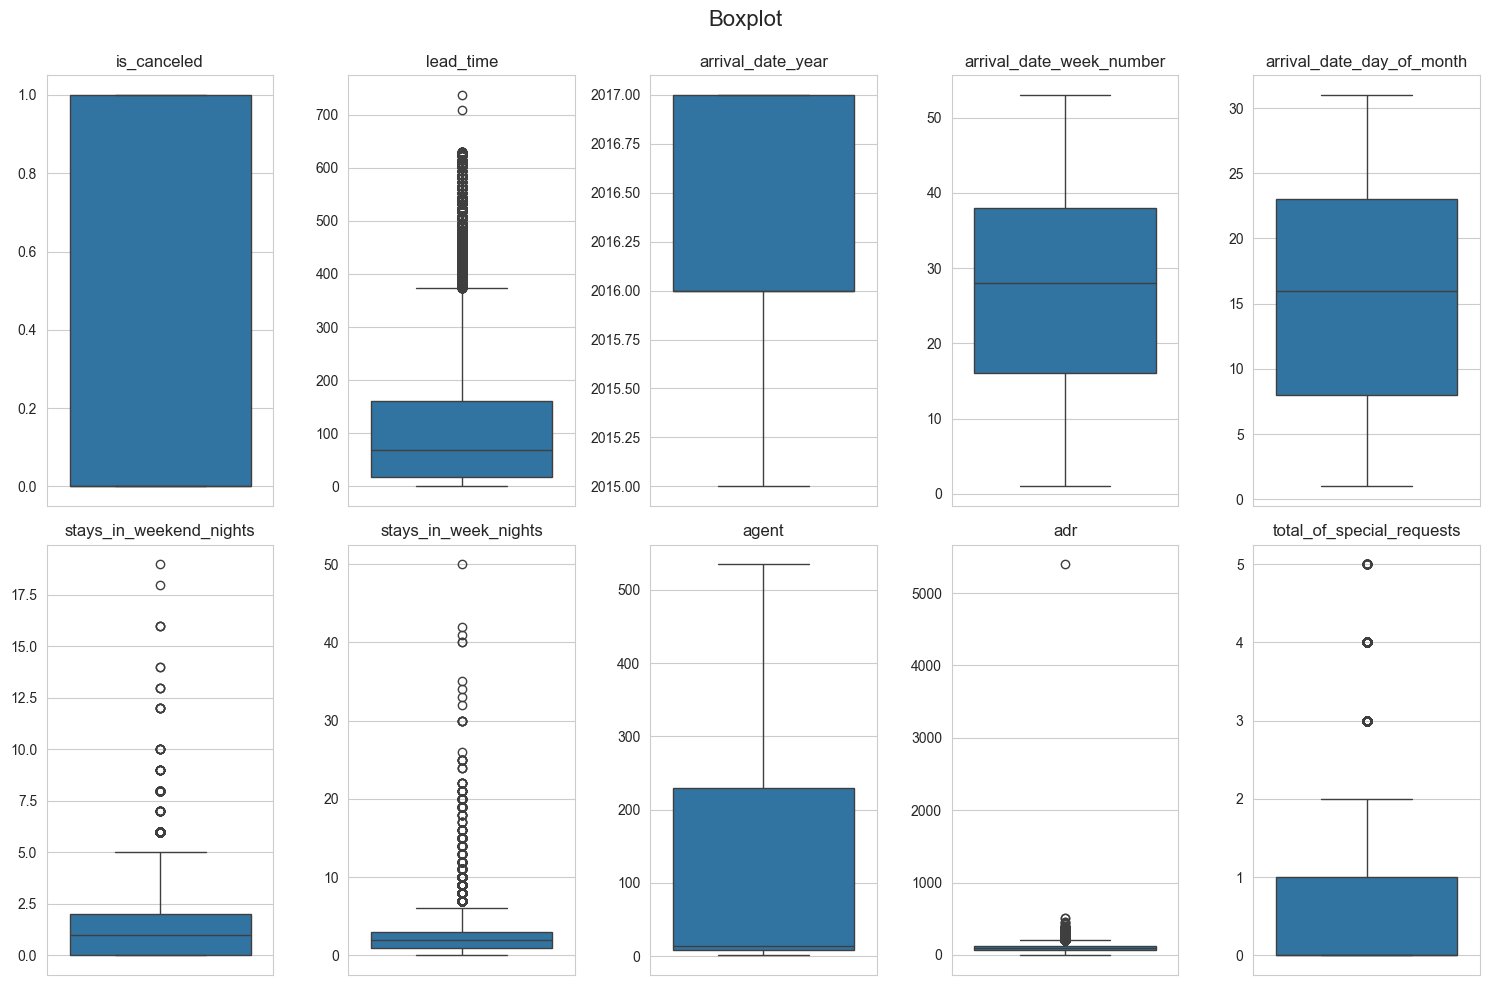

In [12]:
boxplot_visualization(data, numerical_columns_box,"Boxplot")

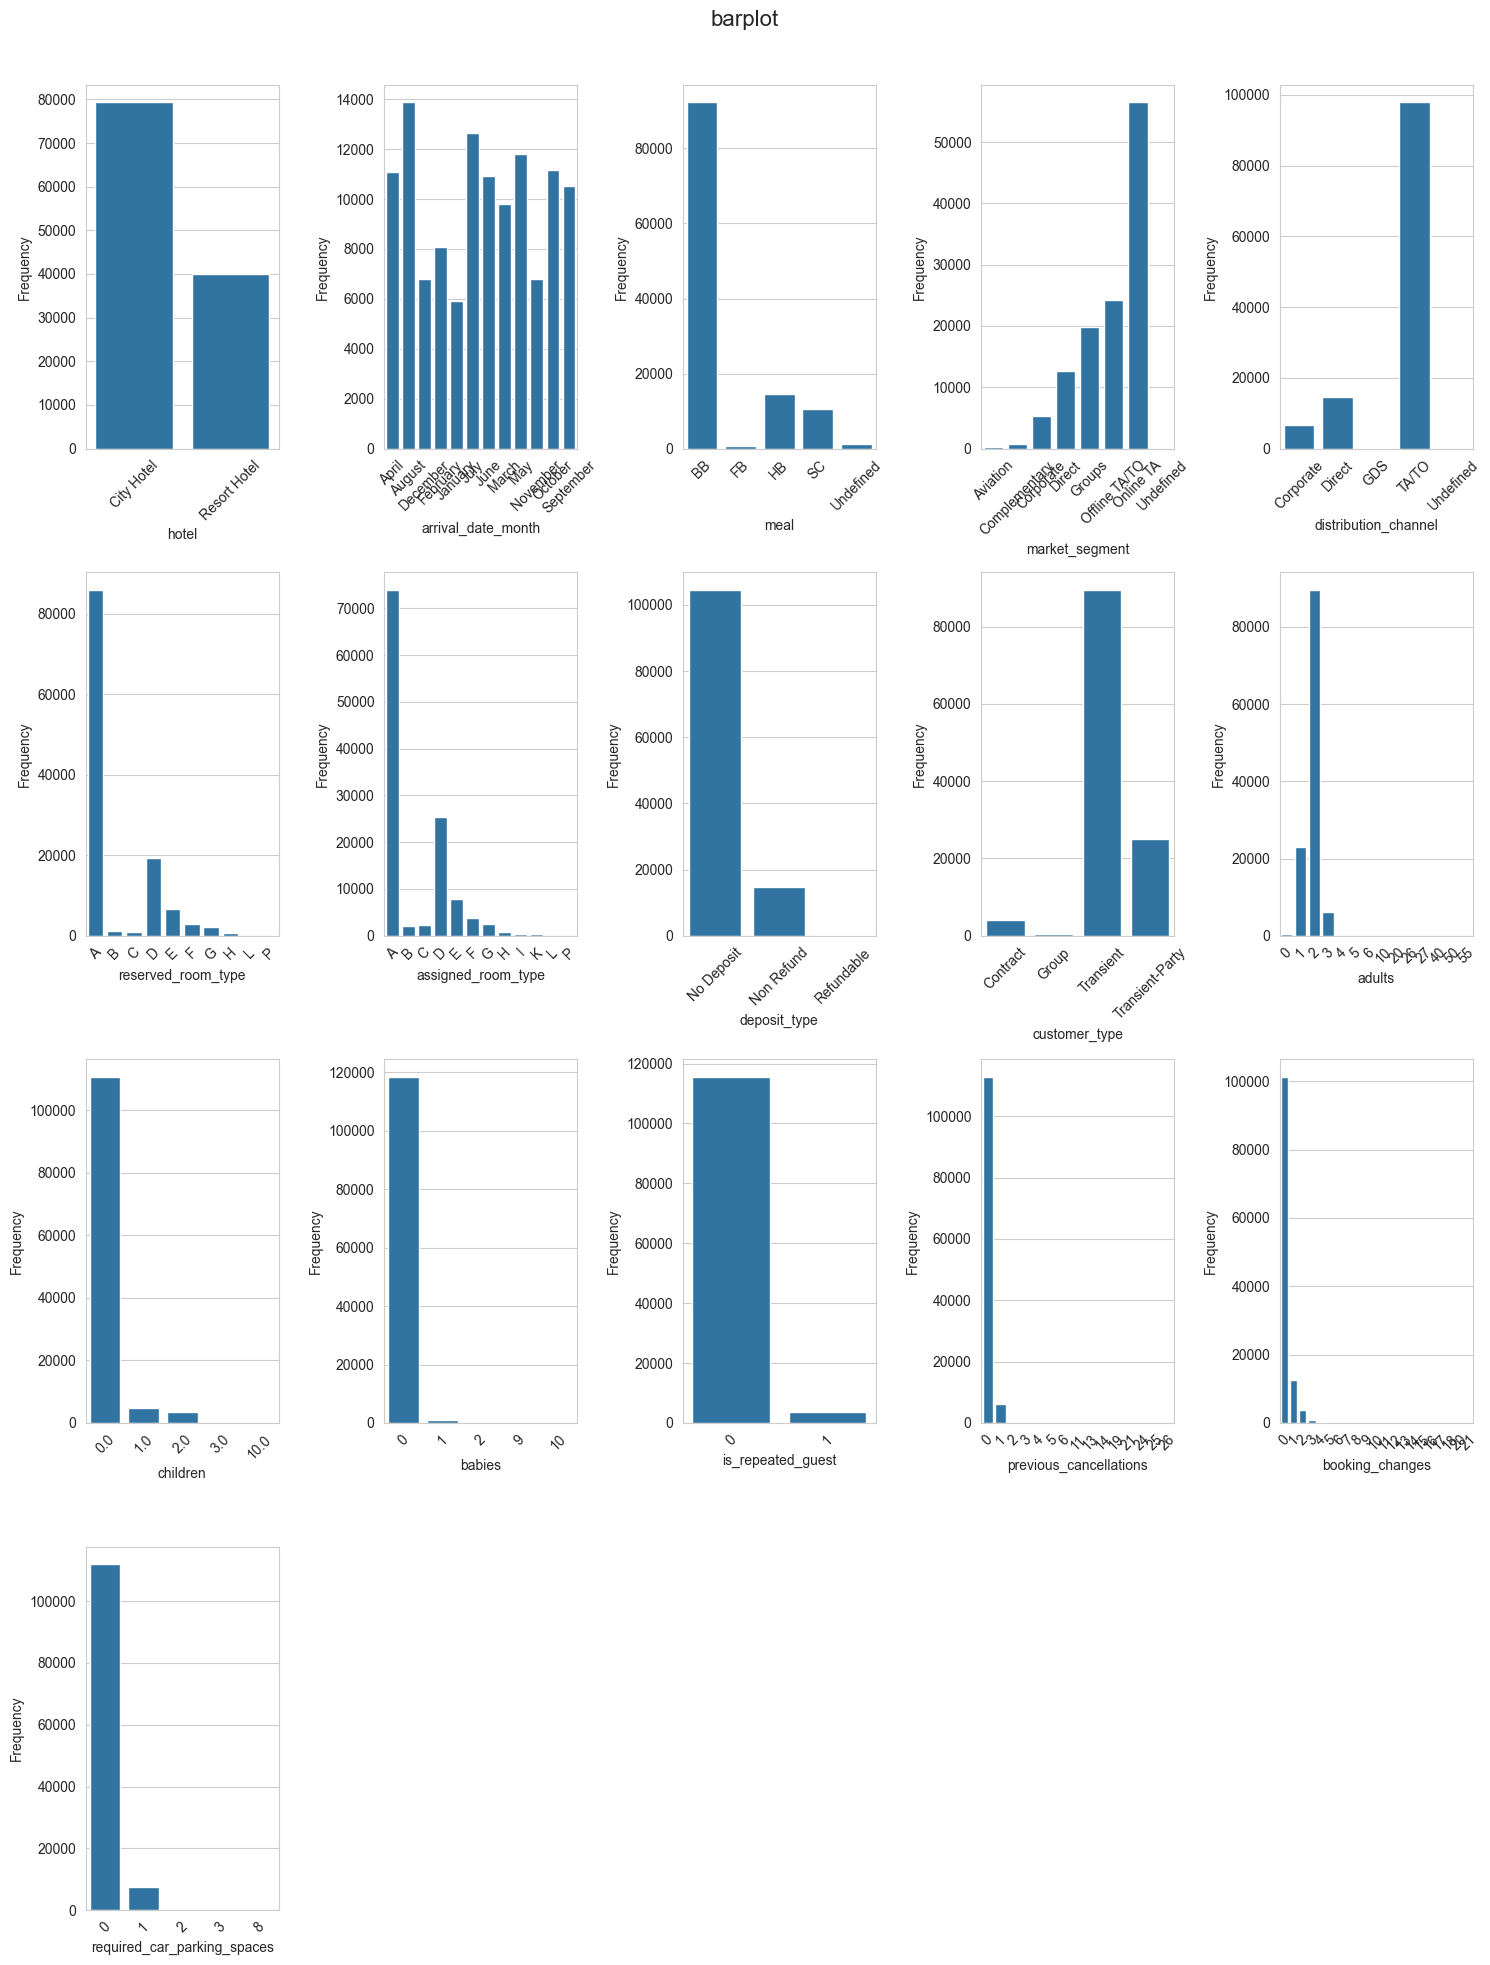

In [13]:
barplot_visualization(data, categorical_columns_barplot + numerical_columns_barplot,"barplot")

We can observe that the majority of the features are imbalanced, with some categories having a much higher frequency than others. 

##### Bivariate Analysis

In [14]:
def boxplot_by_type_visualization(data, columns, title):
    columns = [col for col in columns if col != 'is_canceled']
    n_cols = min(4, len(columns))
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

    axes = axes.flatten()
    for i, col in enumerate(columns):
        sns.boxplot(x='is_canceled', y=col, data=data, ax=axes[i])
        axes[i].set_xlabel('is_canceled')
        axes[i].set_ylabel(col)

    for j in range(len(columns), len(axes)):
        axes[j].axis("off")

    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.suptitle(title, fontsize=16)
    plt.show()

def crosstab_by_type_visualization(data, columns, title):
    n_cols = min(4, len(columns))
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10 * n_rows))

    axes = axes.flatten()
    for i, col in enumerate(columns):
        crosstab_result = pd.crosstab(data[col], data['is_canceled'])
        crosstab_result.plot(kind="bar", ax=axes[i])
        axes[i].set_xlabel('is_canceled')
        axes[i].set_ylabel(col)
        axes[i].tick_params(axis="x", rotation=45)

    for j in range(len(columns), len(axes)):
        axes[j].axis("off")

    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.suptitle(title, fontsize=16)
    plt.show()

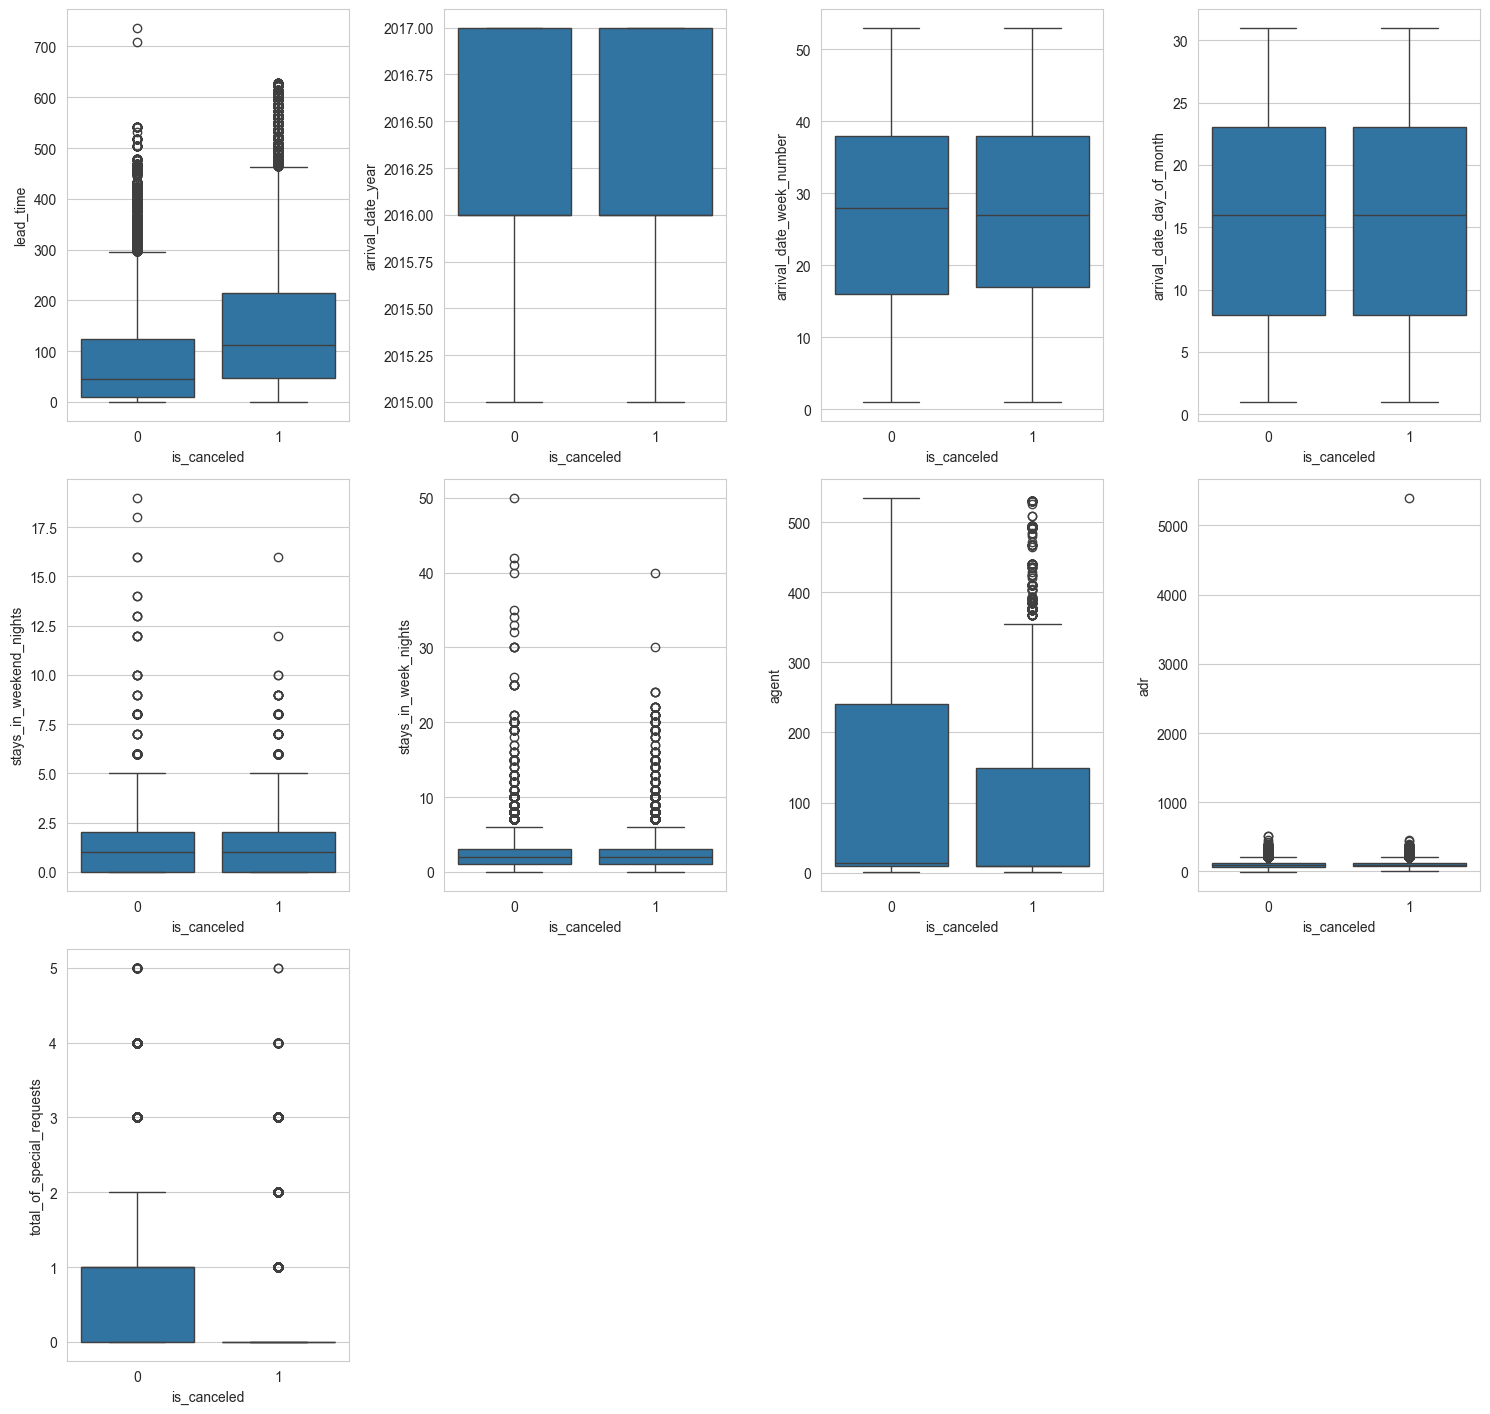

In [15]:
boxplot_by_type_visualization(data, numerical_columns_box,'')

We can differentiate the distribution of the numerical features between the two classes of the target variable. For example, the lead time for canceled bookings is higher than for non-canceled bookings. The target column is unbalanced, with more non-canceled bookings than canceled bookings.
This information can be useful for the model to learn patterns and make predictions.

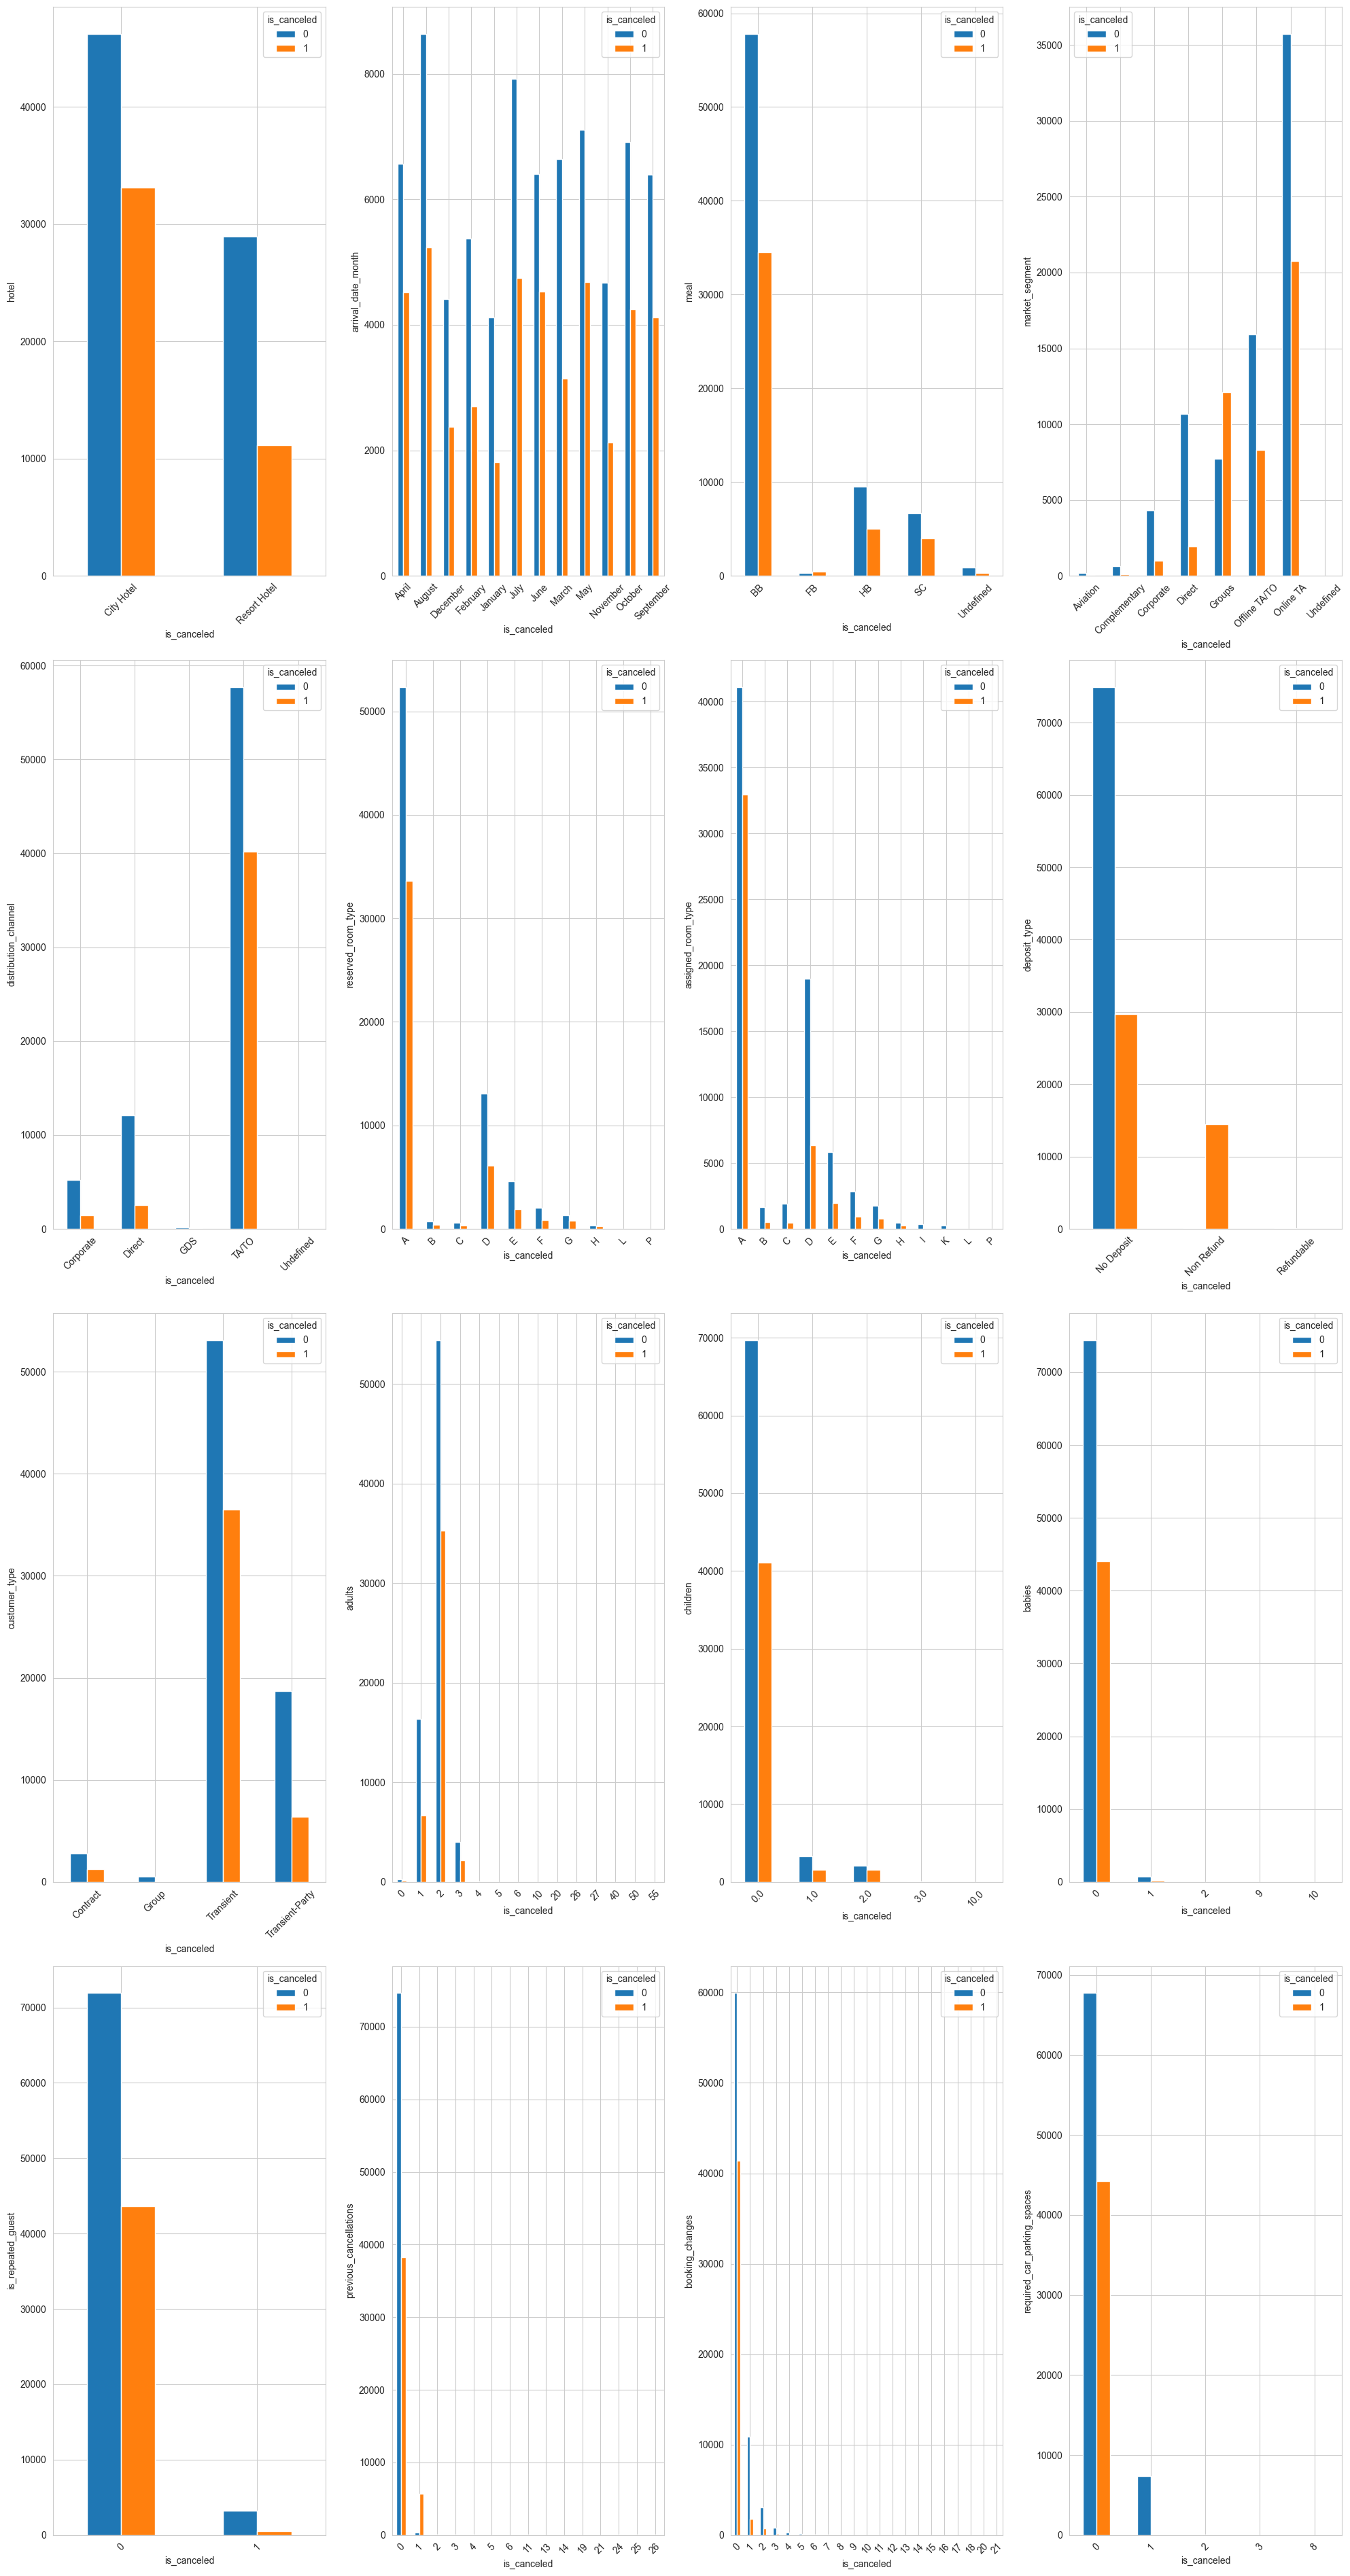

In [16]:
crosstab_by_type_visualization(data, categorical_columns_barplot + numerical_columns_barplot,'')

Some values have a higher frequency of cancellations than others. For example, bookings with a deposit type of 'Non Refund' are almost associated with cancellations. The other features show a smaller frequency of cancellations when comparing to the total number of bookings, which may reflect the imbalanced nature of the dataset.



## Data preparation

### Data Cleaning

##### Dealing with missing values

In [17]:
# Number of missing values in incomplete columns

data.isnull().sum()[data.isnull().sum() > 0]

children         4
country        488
agent        16340
company     112593
dtype: int64

In [18]:
# Percentage of missing values in incomplete columns

data.isnull().sum()[data.isnull().sum() > 0]/len(data) * 100

children     0.003350
country      0.408744
agent       13.686238
company     94.306893
dtype: float64

Given the large number of missing values (94.3%) in the company column, we can drop it.
The children and agent columns have a small number of missing values so we can fill them with 0, assuming that the missing values are due to the absence of children or agents.
The country column has a small number of missing values, so we can fill them with the most frequent value.


In [19]:
# Assigning the new values to the columns and dropping the company column

data.drop(columns=['company'], axis = 1, inplace=True)
data[['children','agent']] = data[['children','agent']].fillna(0)
data['country'] = data['country'].fillna(data['country'].mode().iloc[0])

##### Resolve inconsistencies

In [20]:
# Drop the rows that have a total of 0 nights booked and 0 guests and the duplicate rows.

data = data[data['stays_in_weekend_nights'] + data['stays_in_week_nights'] > 0]
data = data[(data['adults'] + data['children'] + data['babies']) > 0]
data = data.drop_duplicates()

##### Encoding

In [21]:
# Encoding with LabelEncoder and OneHotEncoder

label_encoder = LabelEncoder()
data_encoded = data.copy()
for col in data.select_dtypes(include='object').columns:
    data_encoded[col] = label_encoder.fit_transform(data[col])
    
data_dummies = pd.get_dummies(data, columns=data.select_dtypes(include='object').columns)

#### Data Preprocessing

In [22]:
# Splitting the data into features and target

X = data.drop(columns=['is_canceled'])
y = data['is_canceled']

X_encoded = data_encoded.drop(columns=['is_canceled'])
y_encoded = data_encoded['is_canceled']

X_dummies = data_dummies.drop(columns=['is_canceled'])
y_dummies = data_dummies['is_canceled']


# Train-test split using holdout as our dataset is medium-sized
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)
X_train_dummies, X_test_dummies, y_train_dummies, y_test_dummies = train_test_split(X_dummies, y_dummies, test_size=0.2, random_state=42)

#### Scaling

In [23]:
# Using StandardScaler to obtain a normal distribution in the data

scaler = StandardScaler()
X_train_encoded_scaled = scaler.fit_transform(X_train_encoded)
X_test_encoded_scaled = scaler.transform(X_test_encoded)

X_train_dummies_scaled = scaler.fit_transform(X_train_dummies)
X_test_dummies_scaled = scaler.transform(X_test_dummies)

#### Modelling - Baseline

Some models require additional attention to the type of data they receive. Some models need the data to be encoded as they only work with numerals and others need the data to be scaled to work properly. We will test every model with label encoded and dummy encoded data and we will choose the method that performs better for each case.
Since we are dealing with a classification problem, we will be using the following models as a baseline:
- K-Nearest  (Needs encoded and scaled data)
- Decision Tree (Needs encoded data)
- Neural Network (Needs encoded and scaled data)
- Naive Bayes (Needs encoded data)
- Support Vector Machine (Needs encoded and scaled data)

In [24]:
# Initializing the models

KNN = KNeighborsClassifier()
KNN_dummies = KNeighborsClassifier()
DT = DecisionTreeClassifier()
DT_dummies = DecisionTreeClassifier()
NN = MLPClassifier()
NN_dummies = MLPClassifier()
NB = GaussianNB()
NB_dummies = GaussianNB()
SVM = SVC()
SVM_dummies = SVC()

In [25]:
# Fitting the models using the same split data to ensure a fair comparison

KNN.fit(X_train_encoded_scaled, y_train_encoded)
KNN_dummies.fit(X_train_dummies_scaled, y_train_dummies)

DT.fit(X_train_encoded, y_train_encoded)
DT_dummies.fit(X_train_dummies, y_train_dummies)

NN.fit(X_train_encoded_scaled, y_train_encoded)
NN_dummies.fit(X_train_dummies_scaled, y_train_dummies)

NB.fit(X_train_encoded, y_train_encoded)
NB_dummies.fit(X_train_dummies, y_train_dummies)

SVM.fit(X_train_encoded_scaled, y_train_encoded)
SVM_dummies.fit(X_train_dummies_scaled, y_train_dummies)

SVC()

#### Evaluation

In [26]:
# Predicting the target variable

y_pred_KNN = KNN.predict(X_test_encoded_scaled)
y_pred_KNN_dummies = KNN_dummies.predict(X_test_dummies_scaled)
y_pred_DT = DT.predict(X_test_encoded)
y_pred_DT_dummies = DT_dummies.predict(X_test_dummies)
y_pred_NN = NN.predict(X_test_encoded_scaled)
y_pred_NN_dummies = NN_dummies.predict(X_test_dummies_scaled)
y_pred_NB = NB.predict(X_test_encoded)
y_pred_NB_dummies = NB_dummies.predict(X_test_dummies)
y_pred_SVM = SVM.predict(X_test_encoded_scaled)
y_pred_SVM_dummies = SVM_dummies.predict(X_test_dummies_scaled)

In [36]:
def classification_report_print(y_test, y_pred):   
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    df = pd.DataFrame(report_dict).transpose()
    
    # Calcular a acurácia
    accuracy = accuracy_score(y_test,y_pred)
    
    # Adicionar a linha de accuracy
    df.loc['accuracy'] = ["", "", round(accuracy, 2), len(y_test)]
    
    # Adicionar linha vazia
    df.loc[''] = ["", "", "", ""]  # Linha vazia
    
    # Reorganizar as linhas
    df = df.reindex(['0', '1', '', 'accuracy', 'macro avg', 'weighted avg'])
    
    # Arredondar a duas casas decimais para o DataFrame
    df.iloc[:-1, 2] = df.iloc[:-1, 2].apply(lambda x: round(x, 2) if isinstance(x, float) else x)

    return df.round(2)

In [37]:
# Evaluating and printing the classification report for the models
print("KNN Report:")
display(classification_report_print(y_test_encoded, y_pred_KNN))

print("KNN Dummies Report:")
display(classification_report_print(y_test_dummies, y_pred_KNN_dummies))

print("Decision Tree Report:")
display(classification_report_print(y_test_encoded, y_pred_DT))

print("Decision Tree Dummies Report:")
display(classification_report_print(y_test_dummies, y_pred_DT_dummies))

print("Neural Network Report:")
display(classification_report_print(y_test_encoded, y_pred_NN))

print("Neural Network Dummies Report:")
display(classification_report_print(y_test_dummies, y_pred_NN_dummies))

print("Naive Bayes Report:")
display(classification_report_print(y_test_encoded, y_pred_NB))

print("Naive Bayes Dummies Report:")
display(classification_report_print(y_test_dummies, y_pred_NB_dummies))

print("Support Vector Machine Report:")
display(classification_report_print(y_test_encoded, y_pred_SVM))

print("Support Vector Machine Dummies Report:")
display(classification_report_print(y_test_dummies, y_pred_SVM_dummies))

KNN Report:


,precision,recall,f1-score,support
0,0.843471,0.873187,0.86,12546.0
1,0.628531,0.569735,0.6,4725.0
,,,,
accuracy,,,0.79,17271.0
macro avg,0.736001,0.721461,0.73,17271.0
weighted avg,0.784668,0.790168,0.786837,17271.0


KNN Dummies Report:


,precision,recall,f1-score,support
0,0.829769,0.859796,0.84,12546.0
1,0.588153,0.53164,0.56,4725.0
,,,,
accuracy,,,0.77,17271.0
macro avg,0.708961,0.695718,0.7,17271.0
weighted avg,0.763668,0.770019,0.766259,17271.0


Decision Tree Report:


,precision,recall,f1-score,support
0,0.864139,0.859318,0.86,12546.0
1,0.631908,0.64127,0.64,4725.0
,,,,
accuracy,,,0.8,17271.0
macro avg,0.748024,0.750294,0.75,17271.0
weighted avg,0.800605,0.799664,0.80012,17271.0


Decision Tree Dummies Report:


,precision,recall,f1-score,support
0,0.86672,0.864578,0.87,12546.0
1,0.642767,0.646984,0.64,4725.0
,,,,
accuracy,,,0.81,17271.0
macro avg,0.754743,0.755781,0.76,17271.0
weighted avg,0.805451,0.805049,0.805247,17271.0


Neural Network Report:


,precision,recall,f1-score,support
0,0.856898,0.916866,0.89,12546.0
1,0.72888,0.593439,0.65,4725.0
,,,,
accuracy,,,0.83,17271.0
macro avg,0.792889,0.755153,0.77,17271.0
weighted avg,0.821875,0.828383,0.822495,17271.0


Neural Network Dummies Report:


,precision,recall,f1-score,support
0,0.859882,0.904432,0.88,12546.0
1,0.705767,0.608677,0.65,4725.0
,,,,
accuracy,,,0.82,17271.0
macro avg,0.782824,0.756554,0.77,17271.0
weighted avg,0.817719,0.823519,0.81923,17271.0


Naive Bayes Report:


,precision,recall,f1-score,support
0,0.922094,0.2934,0.45,12546.0
1,0.332405,0.93418,0.49,4725.0
,,,,
accuracy,,,0.47,17271.0
macro avg,0.627249,0.61379,0.47,17271.0
weighted avg,0.760767,0.468705,0.457517,17271.0


Naive Bayes Dummies Report:


,precision,recall,f1-score,support
0,0.901148,0.350231,0.5,12546.0
1,0.342315,0.897989,0.5,4725.0
,,,,
accuracy,,,0.5,17271.0
macro avg,0.621732,0.62411,0.5,17271.0
weighted avg,0.748263,0.500087,0.502028,17271.0


Support Vector Machine Report:


,precision,recall,f1-score,support
0,0.838279,0.930018,0.88,12546.0
1,0.738067,0.523598,0.61,4725.0
,,,,
accuracy,,,0.82,17271.0
macro avg,0.788173,0.726808,0.75,17271.0
weighted avg,0.810863,0.818829,0.80813,17271.0


Support Vector Machine Dummies Report:


,precision,recall,f1-score,support
0,0.82796,0.93751,0.88,12546.0
1,0.744209,0.482751,0.59,4725.0
,,,,
accuracy,,,0.81,17271.0
macro avg,0.786084,0.710131,0.73,17271.0
weighted avg,0.805047,0.813097,0.798982,17271.0


The Decision Tree and the Naive Bayes obtained better results when using the dummy encoded data, while the KNN, Neural Network and Support Vector Machine models obtained better results when using the label encoded data. We will continue this analysis using the best method for each model.
When we evaluate the recall of the models, we can conclude that the recall for the 0 class, that represents that the booking is not going to be canceled, is very high meaning that the percentage of cases in which 0 is being classified as 1 is low. On the other hand, the recall of the 1 class is low, meaning that it is often being misclassified.
Naive Bayes is an exception, having the recall for the 1 class very high and for 0 low.
We will look into the possibility of combining some of the models to improve the predictions.

#### Confusion matrices

In [61]:
def plot_confusion_matrix(y_true, y_pred, suffix=''):
    title='Confusion Matrix '
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(2, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    
    plt.title(title+suffix)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

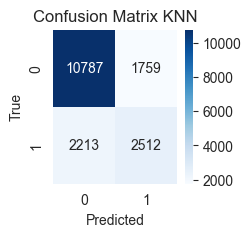

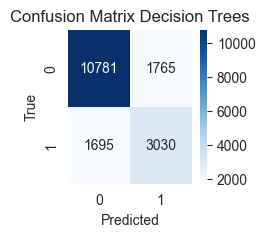

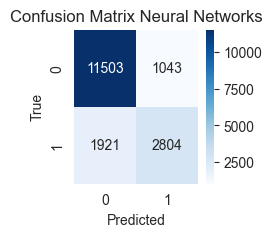

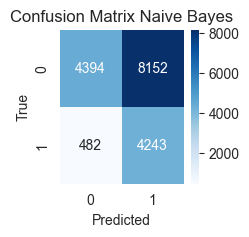

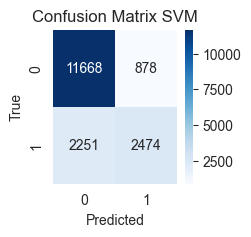

In [68]:
# Plot the Confusion Matrices of the models

plot_confusion_matrix(y_test_encoded, y_pred_KNN_dummies,suffix='KNN')
plot_confusion_matrix(y_test_encoded, y_pred_DT, suffix='Decision Trees')
plot_confusion_matrix(y_test_encoded, y_pred_NN, suffix='Neural Networks')
plot_confusion_matrix(y_test_encoded, y_pred_NB_dummies, suffix='Naive Bayes')
plot_confusion_matrix(y_test_encoded, y_pred_SVM, suffix='SVM')

When looking into the confusion matrices, we can conclude that the majority of the models have the number of False Positives and False Negatives in the same magnitude, meaning that they are not being biased towards one class.
Naive Bayes is an exception, having a big number of False Negatives and a small number of False Positives. This shows that the model is biased towards the 1 class. The very low precision of the 1 class is also a sign of this bias, so we can conclude that the model is not performing well despite the low recall of the 1 class.

#### Ensemble Models

We will try to combine the models to improve the predictions.

In [58]:
# Weighted Average Ensemble

weight_1 = 0.7
weight_2 = 0.3
y_pred_proba = weight_1 * NN.predict_proba(X_test_encoded_scaled) + weight_2 * NB_dummies.predict_proba(X_test_dummies)
y_pred_WAE = np.argmax(y_pred_proba, axis=1)
classification_report_print(y_test_encoded, y_pred_WAE)

,precision,recall,f1-score,support
0,0.896992,0.839152,0.87,12546.0
1,0.635345,0.744127,0.69,4725.0
,,,,
accuracy,,,0.81,17271.0
macro avg,0.766169,0.791639,0.78,17271.0
weighted avg,0.825411,0.813155,0.81741,17271.0


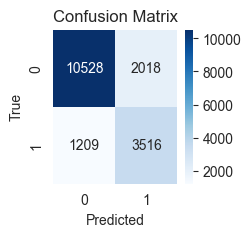

In [55]:
# Confusion matrix of Weighted Average Ensemble

plot_confusion_matrix(y_test_encoded, y_pred_WAE)

In [59]:
# Hybrid Model - Class-Based Model Selection

y_pred_model_1 = NN.predict(X_test_encoded_scaled)
y_pred_model_2 = NB_dummies.predict(X_test_dummies)
y_pred_HM = np.where(y_pred_model_1 == 0, y_pred_model_1, y_pred_model_2)
classification_report_print(y_test_encoded, y_pred_HM)

,precision,recall,f1-score,support
0,0.84541,0.933684,0.89,12546.0
1,0.756369,0.546667,0.63,4725.0
,,,,
accuracy,,,0.83,17271.0
macro avg,0.800889,0.740175,0.76,17271.0
weighted avg,0.82105,0.827804,0.81822,17271.0


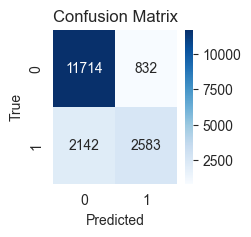

In [60]:
# Confusion matrix of Hybrid Model

plot_confusion_matrix(y_test_encoded, y_pred_HM)

Given the nature of the problem, where False Positives may be more harmful than False Negatives, we can conclude that the Weighted Average Ensemble model is the best model so far. It has a high recall for both classes despite having a lower precision for the 1 class. This shows that there is still room for improvement in the model.

#### ROC Curve

We will plot the ROC curve for the compatible models to evaluate their performance.

In [69]:
from sklearn.metrics import roc_curve, auc

# Weighted Average Ensemble (WAE) probabilities
weight_1 = 0.7
weight_2 = 0.3
y_pred_proba_wae = (weight_1 * NN.predict_proba(X_test_encoded_scaled) +
                    weight_2 * NB_dummies.predict_proba(X_test_dummies))

# Calculate ROC and AUC values for each model
fpr_wae, tpr_wae, _ = roc_curve(y_test_encoded, y_pred_proba_wae[:, 1])
auc_wae = auc(fpr_wae, tpr_wae)

# Individual model probabilities
y_pred_proba_nn = NN.predict_proba(X_test_encoded_scaled)
y_pred_proba_nb = NB_dummies.predict_proba(X_test_dummies)
y_pred_proba_svm = SVM.decision_function(X_test_encoded_scaled) if hasattr(SVM, "decision_function") else SVM.predict_proba(X_test_encoded_scaled)[:, 1]

# Calculate ROC and AUC for individual models
fpr_nn, tpr_nn, _ = roc_curve(y_test_encoded, y_pred_proba_nn[:, 1])
auc_nn = auc(fpr_nn, tpr_nn)

fpr_nb, tpr_nb, _ = roc_curve(y_test_encoded, y_pred_proba_nb[:, 1])
auc_nb = auc(fpr_nb, tpr_nb)

fpr_svm, tpr_svm, _ = roc_curve(y_test_encoded, y_pred_proba_svm)
auc_svm = auc(fpr_svm, tpr_svm)

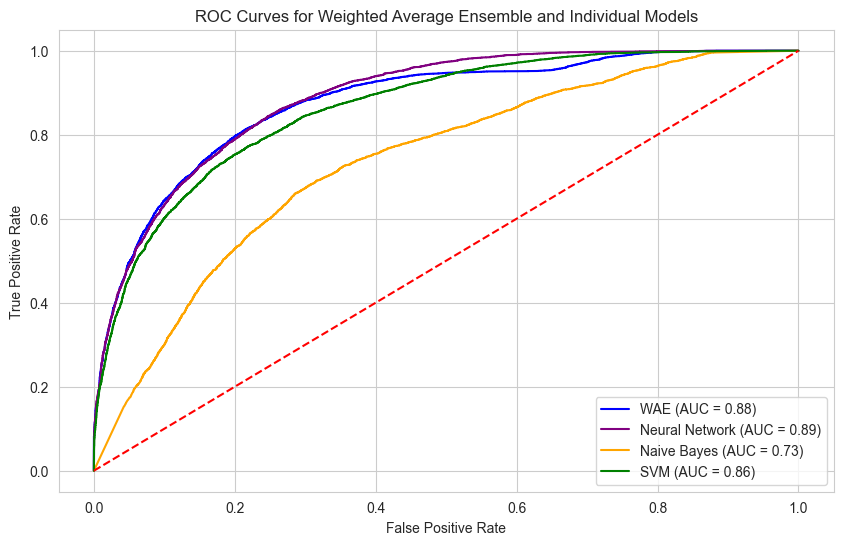

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot ROC curves for each model
plt.plot(fpr_wae, tpr_wae, color='blue', label=f'WAE (AUC = {auc_wae:.2f})')
plt.plot(fpr_nn, tpr_nn, color='purple', label=f'Neural Network (AUC = {auc_nn:.2f})')
plt.plot(fpr_nb, tpr_nb, color='orange', label=f'Naive Bayes (AUC = {auc_nb:.2f})')
plt.plot(fpr_svm, tpr_svm, color='green', label=f'SVM (AUC = {auc_svm:.2f})')

# Plot the random chance line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Weighted Average Ensemble and Individual Models')
plt.legend(loc="lower right")
plt.show()

The ROC curve shows that the Weighted Average Ensemble model and the Neural Networks had the highest AUC value, meaning that they performed the best among the models. The SVM model has similar AUC values, but the Naive Bayes model has the lowest AUC value.
Since the curve of the best 3 performing models intercept each model is better for some cost ratios than others.

Since Naive Bayes did not perform well and it has no hyperparameters to tune, we will not use it in the next steps.
The SVM model has a low recall for the 1 class, so we will not use it in the next steps.
We will keep KNN, Decision Trees, Neural Networks and evaluate the ensemble models.

In [71]:
DT_dummies.feature_importances_

array([1.48541218e-01, 2.90772940e-02, 5.36072818e-02, 6.39903326e-02,
       2.00085153e-02, 3.60621687e-02, 9.54382459e-03, 6.20018920e-03,
       1.34214128e-03, 7.37464285e-04, 1.41923182e-02, 5.93788537e-03,
       1.73776563e-02, 5.94075624e-02, 5.95863695e-04, 7.86861354e-02,
       3.73079046e-02, 7.10727823e-02, 1.64994246e-03, 1.75258234e-03,
       3.27901535e-03, 3.08869642e-03, 9.92250058e-04, 1.94564578e-03,
       1.45879244e-03, 3.58561801e-03, 3.43683363e-03, 2.76956456e-03,
       3.76392396e-03, 2.14686867e-03, 1.66831378e-03, 2.50750008e-03,
       4.95560804e-03, 4.17298698e-04, 3.80814823e-03, 3.48377851e-03,
       5.83875939e-04, 6.50345532e-05, 1.89317182e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.03217409e-04, 4.39321400e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.73010212e-04, 1.73696733e-03, 1.25649387e-04, 0.00000000e+00,
       3.10003285e-03, 0.00000000e+00, 0.00000000e+00, 6.78291808e-05,
      

In [85]:
DT_dummies.get_depth()

46

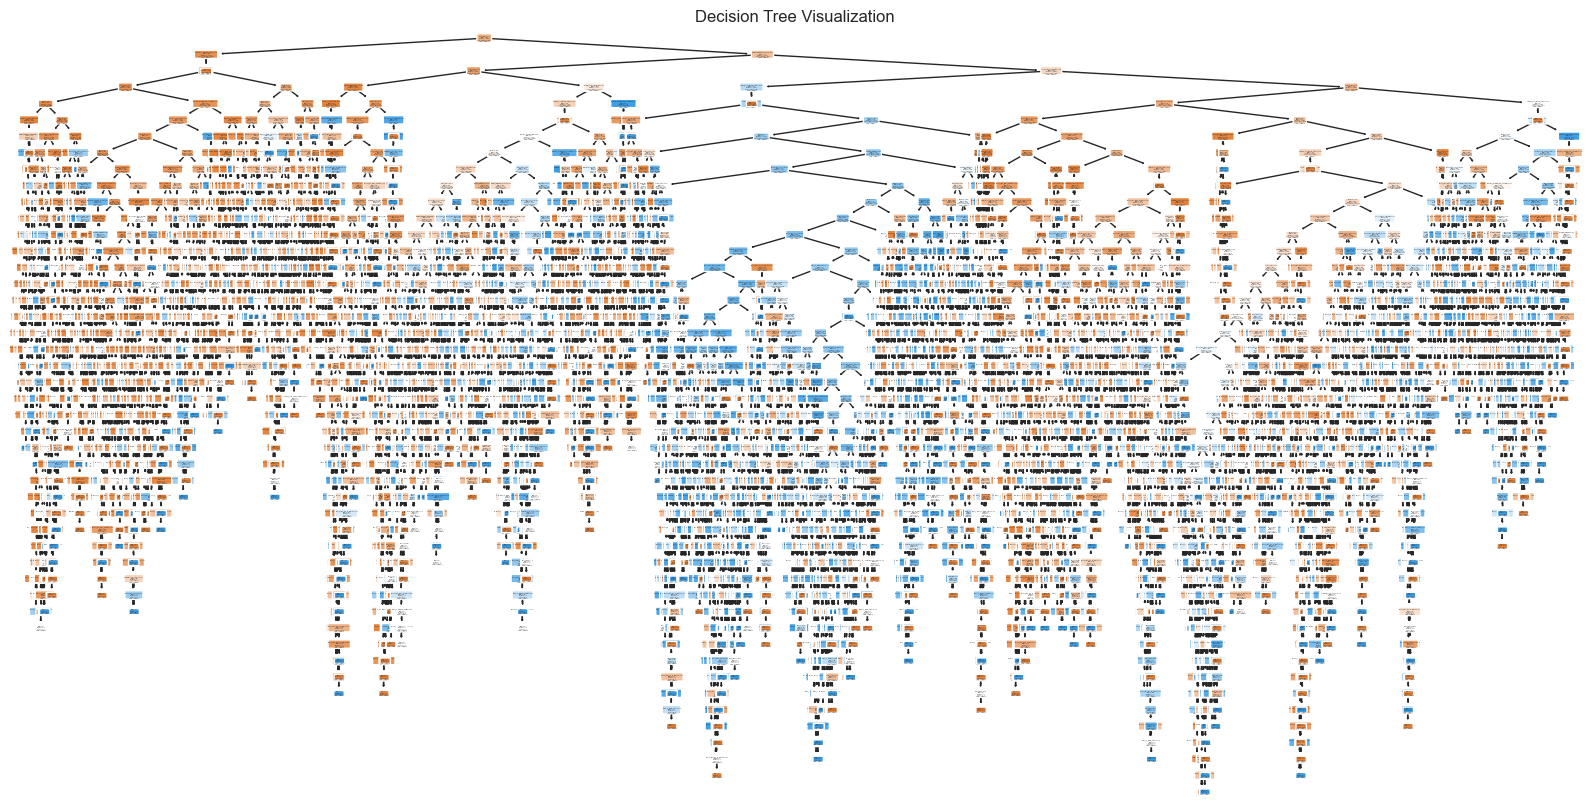

In [78]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the tree
plt.figure(figsize=(20, 10))  # Adjust size as needed
plot_tree(DT_dummies, feature_names=X_dummies.columns, class_names=['Class 0', 'Class 1'], filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()


In [76]:
X_test_dummies_scaled

array([[-0.46572135, -0.30992606, -1.74254422, ..., -0.0786772 ,
         0.46002293, -0.39154247],
       [-0.12792521,  1.14747112, -0.27875872, ..., -0.0786772 ,
         0.46002293, -0.39154247],
       [-0.66373977, -0.30992606, -1.44978712, ..., -0.0786772 ,
         0.46002293, -0.39154247],
       ...,
       [-0.05803636, -1.76732325,  0.16037693, ..., -0.0786772 ,
         0.46002293, -0.39154247],
       [-0.93164705,  1.14747112, -0.351948  , ..., -0.0786772 ,
         0.46002293, -0.39154247],
       [-0.85011005, -1.76732325,  1.03864822, ..., -0.0786772 ,
        -2.17380469, -0.39154247]])

In [75]:
X_test_dummies

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
46660,40,2016,3,14,1,3,2,0.0,0,0,...,False,False,False,True,False,False,False,False,True,False
113626,69,2017,23,8,0,2,2,0.0,0,0,...,False,False,False,True,False,False,False,False,True,False
83645,23,2016,7,7,2,1,2,0.0,0,0,...,False,False,False,True,False,False,False,False,True,False
96305,121,2016,36,31,0,1,2,1.0,1,0,...,False,False,False,True,False,False,False,False,True,False
88185,3,2016,18,29,1,2,2,2.0,0,0,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72104,11,2017,29,21,0,1,2,0.0,0,0,...,False,False,False,True,False,False,False,False,True,False
23245,31,2016,17,18,1,1,2,0.0,0,0,...,False,False,False,True,False,False,False,False,True,False
369,75,2015,29,13,1,4,2,0.0,0,0,...,False,False,False,True,False,False,False,False,True,False
113034,0,2017,22,30,0,2,2,0.0,0,0,...,False,False,False,True,False,False,False,False,True,False


In [72]:
DT.feature_importances_

array([0.00253478, 0.1523933 , 0.02582961, 0.02106247, 0.05939004,
       0.07626112, 0.02398033, 0.0435295 , 0.01138246, 0.00758004,
       0.0008925 , 0.01075619, 0.14378394, 0.0481222 , 0.00380745,
       0.00148139, 0.01451593, 0.00511219, 0.01234342, 0.01941914,
       0.0186784 , 0.01875035, 0.06401866, 0.00043873, 0.01894426,
       0.08906667, 0.03457149, 0.07135346])

In [ ]:
break

##### Remove Outliers

eu nos decidimos usar o lof, para detetar outliers, 
para conseguirmos usar o lof, os dados precisoam de estar encoder, logo vamos usar o labelEncoder para isso

In [ ]:
label_encoder = LabelEncoder()
encoded_data = data.copy()
for col in data.columns: 
    encoded_data[col] = label_encoder.fit_transform(data[col])

In [ ]:
lof = LocalOutlierFactor(contamination=0.1)
outliers = lof.fit_predict(encoded_data)
outlier_index = encoded_data.index[outliers == -1]

Valores marcados com -1 são outliers, logo vamos retira-los, e dropar a coluna 'LOF'

In [ ]:
data = data.drop(index=outlier_index)
encoded_data = encoded_data.drop(index=outlier_index)

### Data Reduction

In [ ]:
corr_matrix = encoded_data.corr(numeric_only=False)

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f")
plt.suptitle('Heatmap visualization', fontsize=16)
plt.show()

Ao analisar a matriz de correlação, podemos ver que a correlação entre algumas features é alta, o que pode indicar redundância de informação. Podemos analisar a possibilidade de remover uma delas.
Verifica-se também que a correlação entre as features e a variável target é baixa, por isso vamos tentar criar features.

Vamos analizar a distribuição da feature 'arrival_date_week_number' para perceber como a podemos agrupar

In [ ]:
data['arrival_date_week_number'].value_counts().plot(kind='bar')

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['arrival_date_week_number'].value_counts())
plt.xlabel('Arrival Date Week Number')
plt.title('Boxplot of Arrival Date Week Number')
plt.show()

Decidimos agrupar em 4 categorias, com base nos quartis da frequência.

In [ ]:
def lead_time_category(lead_time):
    if lead_time <= 7:
        return 0
    elif 7 < lead_time <= 30:
        return 1
    else:
        return 2
    
week_counts = data['arrival_date_week_number'].value_counts()

# Calcular os quartis das frequências
q1 = week_counts.quantile(0.25)
q2 = week_counts.quantile(0.5)
q3 = week_counts.quantile(0.75)

# Função para categorizar a frequência
def categorize_frequency(week):
    freq = week_counts[week]
    if freq <= q1:
        return 0
    elif q1 < freq <= q2:
        return 1
    elif q2 < freq <= q3:
        return 2
    else:
        return 3

In [ ]:
data['room_type_match'] = (data['reserved_room_type'] == data['assigned_room_type']).astype(int)
data['num_people'] = data['adults'] + data['children'] + data['babies']
data['lead_time_category'] = data['lead_time'].apply(lead_time_category)
data['arrival_date_week_frequency_category'] = data['arrival_date_week_number'].apply(categorize_frequency)

Chisq e anova para selecionar as features

In [ ]:
def FunctionChisq(inpData, TargetVariable, CategoricalVariablesList):
    from scipy.stats import chi2_contingency

    # Creating an empty list of final selected predictors
    SelectedPredictors = []

    for predictor in CategoricalVariablesList:
        CrossTabResult = pd.crosstab(index=inpData[TargetVariable], columns=inpData[predictor])
        ChiSqResult = chi2_contingency(CrossTabResult)

        # If the ChiSq P-Value is <0.05, that means we reject H0
        if (ChiSqResult[1] < 0.05):
            #print(predictor, 'is correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])
            SelectedPredictors.append(predictor)
        else:
            #print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])
            pass

    return (SelectedPredictors)


def FunctionAnova(inpData, TargetVariable, ContinuousPredictorList):
    from scipy.stats import f_oneway

    # Creating an empty list of final selected predictors
    SelectedPredictors = []

    for predictor in ContinuousPredictorList:
        CategoryGroupLists = inpData.groupby(TargetVariable)[predictor].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)

        # If the ANOVA P-Value is <0.05, that means we reject H0
        if (AnovaResults[1] < 0.05):
            #print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            SelectedPredictors.append(predictor)
        else:
            #print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            pass

    return (SelectedPredictors)

In [ ]:
numerical_columns = data.select_dtypes(exclude='object').columns
categorical_columns = data.select_dtypes(include='object').columns

selected_categorical_columns = FunctionChisq(data, 'is_canceled', categorical_columns)
selected_numerical_columns = FunctionAnova(data, 'is_canceled', numerical_columns)

In [ ]:
selected_columns = selected_categorical_columns + selected_numerical_columns
data = data[selected_columns]

In [ ]:
label_encoder = LabelEncoder()
encoded_data = data.copy()
for col in data.columns: 
    encoded_data[col] = label_encoder.fit_transform(data[col])

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(encoded_data.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.suptitle('Heatmap visualization', fontsize=16)
plt.show()

Como as features usadas para criar novas features possuem menor correlação com a variável target do que as novas, vamos removê-las para evitar redundância de colunas. 

In [ ]:
encoded_data = encoded_data.drop(columns=['reserved_room_type','assigned_room_type', 'adults', 'children', 'babies', 'lead_time'])

Como há features com alta correlação entre si vamos remover uma delas, neste caso a que possui menor correlação com a variável target.

In [ ]:
correlation_threshold = 0.7

corr_matrix = encoded_data.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = []

for column in upper_triangle.columns:
    high_corr_features = upper_triangle.index[upper_triangle[column] > correlation_threshold].tolist()
    
    for feature in high_corr_features:
        if corr_matrix[feature]['is_canceled'] < corr_matrix[column]['is_canceled']:
            to_drop.append(feature)
        else:
            to_drop.append(column)

to_drop = list(set(to_drop))
encoded_data = encoded_data.drop(columns=to_drop)

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(encoded_data.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.suptitle('Heatmap visualization', fontsize=16)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif

# Train a RandomForest model (or use another model) and check feature importance
model = RandomForestClassifier()
model.fit(encoded_data.drop(columns=['is_canceled']), encoded_data['is_canceled'])

feature_importances = model.feature_importances_

importance_df = pd.DataFrame({
    'feature': encoded_data.drop(columns=['is_canceled']).columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

In [ ]:
model.score(encoded_data.drop(columns=['is_canceled']), encoded_data['is_canceled'])

In [ ]:
## knn . nb e  ensemble, redes n 